In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.callbacks import LearningRateScheduler
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras import layers
from tensorflow.keras import models
from keras.callbacks import ModelCheckpoint
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow import keras


import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import classification_report
from sklearn.preprocessing import MinMaxScaler
import optuna
from sklearn.model_selection import cross_val_score

In [2]:
def print_error_matrix(y_test,y_pred):
    confusion_mtx = tf.math.confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(10, 8))
    sns.heatmap(confusion_mtx,
                annot=True, fmt='g',
                cmap='coolwarm')
    plt.xlabel('Prediction')
    plt.ylabel('True')
    plt.show()

In [3]:
train=pd.read_csv("dataset_train.csv")
test=pd.read_csv("dataset_test.csv")

scaler = MinMaxScaler()
train = pd.DataFrame(scaler.fit_transform(train), columns=train.columns)

test = pd.DataFrame(scaler.transform(test), columns=test.columns)



X_train = train.iloc[: ,1:].values
y_train = train['arrytmia'].values

X_test = test.iloc[: ,1:].values
y_test = test['arrytmia'].values

In [4]:
_, X_val, _, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

## KNN

In [5]:
def objective(trial):
    n_neighbors = trial.suggest_int('n_neighbors', 1, 1000) # Liczba sąsiadów
    weights = trial.suggest_categorical('weights', ['uniform', 'distance']) #Sposób ważenia sąsiadów
    algorithm = trial.suggest_categorical('algorithm', ['auto', 'ball_tree', 'kd_tree', 'brute'])
    metric=trial.suggest_categorical('metric',['euclidean','manhattan'])
    
    model = KNeighborsClassifier(
        n_neighbors=n_neighbors,
        weights=weights,
        algorithm=algorithm,
        metric=metric,
        n_jobs=-1
    )


    score = cross_val_score(model, X_val, y_val, cv=5, scoring='f1').mean()
    return score 

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=2)

best_params = study.best_params
print("Najlepsze parametry:", best_params)

[I 2025-04-03 19:10:20,259] A new study created in memory with name: no-name-9e0f0157-20cf-4601-bbd5-643d54e48836
[I 2025-04-03 19:10:21,984] Trial 0 finished with value: 0.9586908179645546 and parameters: {'n_neighbors': 786, 'weights': 'uniform', 'algorithm': 'auto', 'metric': 'euclidean'}. Best is trial 0 with value: 0.9586908179645546.
[I 2025-04-03 19:10:23,666] Trial 1 finished with value: 0.967728876219458 and parameters: {'n_neighbors': 243, 'weights': 'uniform', 'algorithm': 'kd_tree', 'metric': 'manhattan'}. Best is trial 1 with value: 0.967728876219458.


Najlepsze parametry: {'n_neighbors': 243, 'weights': 'uniform', 'algorithm': 'kd_tree', 'metric': 'manhattan'}


              precision    recall  f1-score   support

         0.0       0.98      0.16      0.28      1856
         1.0       0.59      1.00      0.74      2257

    accuracy                           0.62      4113
   macro avg       0.79      0.58      0.51      4113
weighted avg       0.77      0.62      0.53      4113



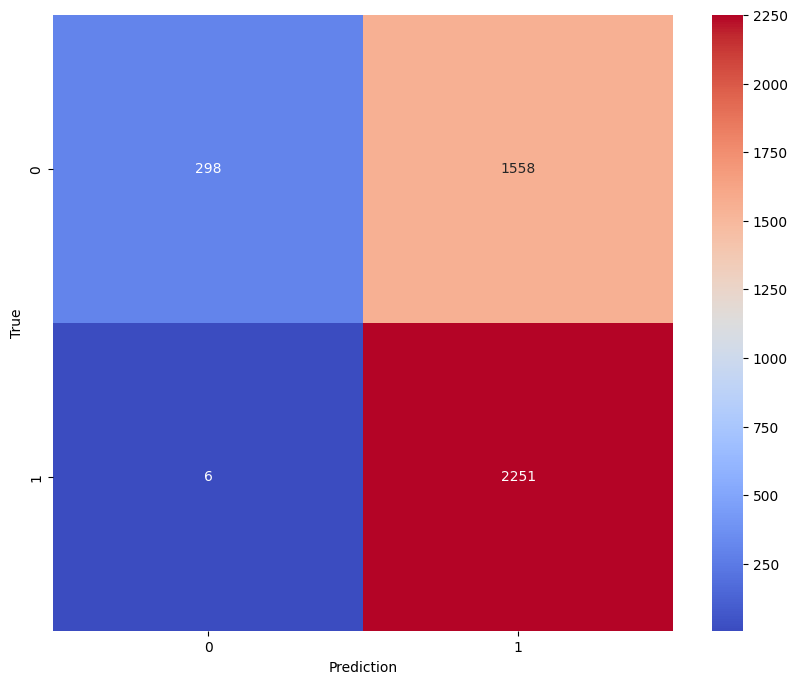

In [6]:
best_model = KNeighborsClassifier(**best_params)
best_model.fit(X_train, y_train)

y_pred = best_model.predict(X_test)

print(classification_report(y_test, y_pred))
print_error_matrix(y_test,y_pred)

## DecisionTree

In [7]:
def objective(trial):
    criterion = trial.suggest_categorical('criterion', ['gini', 'entropy','log_loss']) 
    splitter = trial.suggest_categorical('splitter', ['best', 'random'])
    max_depth = trial.suggest_int('max_depth', 3, 20) 
    min_samples_split = trial.suggest_int('min_samples_split', 2, 20)
    min_samples_leaf = trial.suggest_int('min_samples_leaf', 1, 20)
    max_features = trial.suggest_categorical('max_features', ['sqrt', 'log2', None])
    #DODAJ CCP_ALPHA

    model = DecisionTreeClassifier(
        criterion=criterion,
        max_depth=max_depth,
        min_samples_split=min_samples_split,
        min_samples_leaf=min_samples_leaf,
        max_features=max_features,
        splitter=splitter,
        random_state=42
    )


    score = cross_val_score(model, X_val, y_val, cv=5, scoring='f1').mean()
    return score 

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=2)

best_params = study.best_params
print("Najlepsze parametry:", best_params)

[I 2025-04-03 19:10:27,763] A new study created in memory with name: no-name-3373c838-ff01-4f60-b2e6-c7eff95f03e1
[I 2025-04-03 19:10:27,889] Trial 0 finished with value: 0.9547864969463369 and parameters: {'criterion': 'log_loss', 'splitter': 'best', 'max_depth': 5, 'min_samples_split': 3, 'min_samples_leaf': 17, 'max_features': 'log2'}. Best is trial 0 with value: 0.9547864969463369.
[I 2025-04-03 19:10:27,995] Trial 1 finished with value: 0.9470817692974549 and parameters: {'criterion': 'log_loss', 'splitter': 'best', 'max_depth': 3, 'min_samples_split': 2, 'min_samples_leaf': 7, 'max_features': 'sqrt'}. Best is trial 0 with value: 0.9547864969463369.


Najlepsze parametry: {'criterion': 'log_loss', 'splitter': 'best', 'max_depth': 5, 'min_samples_split': 3, 'min_samples_leaf': 17, 'max_features': 'log2'}


              precision    recall  f1-score   support

         0.0       0.89      0.09      0.16      1856
         1.0       0.57      0.99      0.72      2257

    accuracy                           0.58      4113
   macro avg       0.73      0.54      0.44      4113
weighted avg       0.71      0.58      0.47      4113



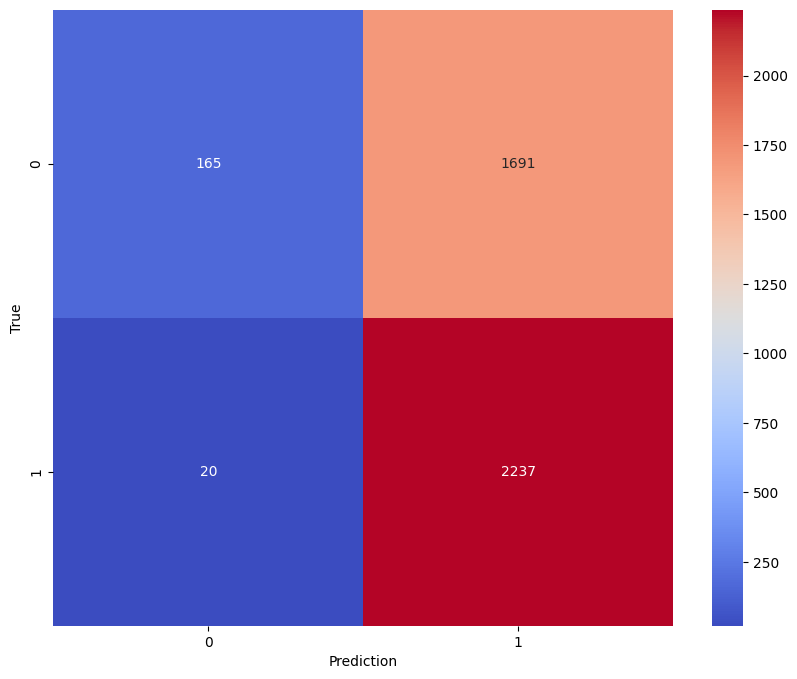

In [8]:
best_model = DecisionTreeClassifier(**best_params, random_state=42)
best_model.fit(X_train, y_train)

y_pred = best_model.predict(X_test)

print(classification_report(y_test, y_pred))
print_error_matrix(y_test,y_pred)

## RandomForestClassifier

In [9]:
def objective(trial):
    n_estimators = trial.suggest_int('n_estimators', 50, 200) # liczba drzew w lesie
    criterion = trial.suggest_categorical('criterion', ['gini', 'entropy', 'log_loss'])
    max_depth = trial.suggest_int('max_depth', 5, 50) # Maksymalna głebokość drzewa
    min_samples_split = trial.suggest_int('min_samples_split', 2, 20) # Minimalna liczba próbek w węźle wymagana do podzielenia
    min_samples_leaf = trial.suggest_int('min_samples_leaf', 1, 20) # minimalna liczba próbek w liściu
    max_features = trial.suggest_categorical('max_features', ['sqrt', 'log2','None']) # Liczba cech rozważanych podczas rodzielania węzła
    
    model = RandomForestClassifier(
        criterion=criterion,
        n_estimators=n_estimators,
        max_depth=max_depth,
        min_samples_split=min_samples_split,
        min_samples_leaf=min_samples_leaf,
        max_features=max_features,
        random_state=42
    )

    
    score = cross_val_score(model, X_val, y_val, cv=5, scoring='f1').mean()
    return score 

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=2)

best_params = study.best_params
print("Najlepsze parametry:", best_params)


[I 2025-04-03 19:10:28,226] A new study created in memory with name: no-name-2febb0a9-199e-4518-8f48-0cb288ff164f
[I 2025-04-03 19:10:49,651] Trial 0 finished with value: 0.9799022152898296 and parameters: {'n_estimators': 189, 'criterion': 'entropy', 'max_depth': 32, 'min_samples_split': 6, 'min_samples_leaf': 15, 'max_features': 'sqrt'}. Best is trial 0 with value: 0.9799022152898296.
[I 2025-04-03 19:11:00,677] Trial 1 finished with value: 0.98186639870089 and parameters: {'n_estimators': 110, 'criterion': 'log_loss', 'max_depth': 35, 'min_samples_split': 12, 'min_samples_leaf': 7, 'max_features': 'log2'}. Best is trial 1 with value: 0.98186639870089.


Najlepsze parametry: {'n_estimators': 110, 'criterion': 'log_loss', 'max_depth': 35, 'min_samples_split': 12, 'min_samples_leaf': 7, 'max_features': 'log2'}


              precision    recall  f1-score   support

         0.0       0.95      0.29      0.44      1856
         1.0       0.63      0.99      0.77      2257

    accuracy                           0.67      4113
   macro avg       0.79      0.64      0.61      4113
weighted avg       0.77      0.67      0.62      4113



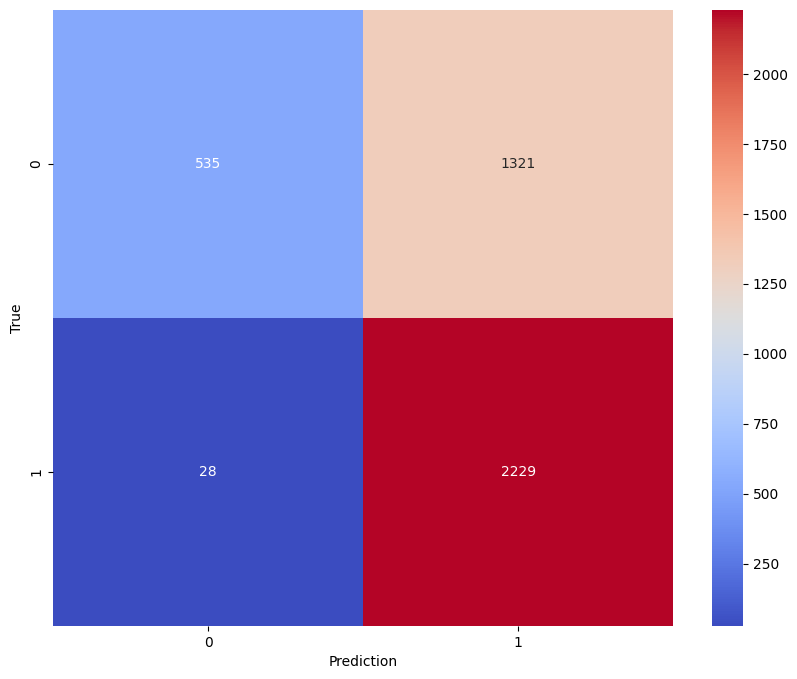

In [10]:
best_model = RandomForestClassifier(**best_params, random_state=42)
best_model.fit(X_train, y_train)

y_pred = best_model.predict(X_test)

print(classification_report(y_test, y_pred))
print_error_matrix(y_test,y_pred)

## SVM

In [11]:
def objective(trial):
    C = trial.suggest_float('C', 1e-5, 1e5,log=True)
    kernel = trial.suggest_categorical('kernel', ['linear', 'poly', 'rbf', 'sigmoid','precomputed'])
    gamma = trial.suggest_categorical('gamma', ['scale', 'auto'])
    
    if kernel == 'poly':
        degree = trial.suggest_int('degree', 2, 5)
        coef0 = trial.suggest_uniform('coef0', -1, 1)
        model = SVC(C=C, kernel=kernel, gamma=gamma, degree=degree, coef0=coef0, random_state=42)
    else:
        model = SVC(C=C, kernel=kernel, gamma=gamma, random_state=42)
    

    
    score = cross_val_score(model, X_val, y_val, cv=5, scoring='f1').mean()
    return score 

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=2)

best_params = study.best_params
print("Najlepsze parametry:", best_params)


[I 2025-04-03 19:11:17,674] A new study created in memory with name: no-name-6d22c0b9-440e-40fa-b837-69923edbc715
[W 2025-04-03 19:11:17,678] Trial 0 failed with parameters: {'C': 11644.505411964794, 'kernel': 'precomputed', 'gamma': 'scale'} because of the following error: ValueError('X should be a square kernel matrix').
Traceback (most recent call last):
  File "c:\Users\Kuba\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\study\_optimize.py", line 196, in _run_trial
    value_or_values = func(trial)
                      ^^^^^^^^^^^
  File "C:\Users\Kuba\AppData\Local\Temp\ipykernel_3012\3041566706.py", line 15, in objective
    score = cross_val_score(model, X_val, y_val, cv=5, scoring='f1').mean()
            ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Kuba\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\_param_validation.py", line 216, in wrapper
    return func(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^

ValueError: X should be a square kernel matrix

In [ ]:
best_model = SVC(**best_params, random_state=42)
best_model.fit(X_train, y_train)

y_pred = best_model.predict(X_test)

print(classification_report(y_test, y_pred))
print_error_matrix(y_test,y_pred)